In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [2]:
# Load sentiment data
sentiment_df = pd.read_csv("/content/fear_greed_index.csv")

# Load trader data
trades_df = pd.read_csv("/content/historical_data.csv")


In [3]:
sentiment_df.head()
trades_df.head()

sentiment_df.info()
trades_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2644 entries, 0 to 2643
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   timestamp       2644 non-null   int64 
 1   value           2644 non-null   int64 
 2   classification  2644 non-null   object
 3   date            2644 non-null   object
dtypes: int64(2), object(2)
memory usage: 82.8+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211224 entries, 0 to 211223
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Account           211224 non-null  object 
 1   Coin              211224 non-null  object 
 2   Execution Price   211224 non-null  float64
 3   Size Tokens       211224 non-null  float64
 4   Size USD          211224 non-null  float64
 5   Side              211224 non-null  object 
 6   Timestamp IST     211224 non-null  object 
 7   Start Position    211224 non-nu

In [6]:
sentiment_df['date'] = pd.to_datetime(sentiment_df['date'])

trades_df['time'] = pd.to_datetime(trades_df['Timestamp IST'], format="%d-%m-%Y %H:%M")
trades_df['trade_date'] = trades_df['time'].dt.date
trades_df['trade_date'] = pd.to_datetime(trades_df['trade_date'])

In [8]:
trades_df = trades_df[
    (trades_df['Closed PnL'].notna()) &
    (trades_df['Size Tokens'] > 0)
]

In [10]:
merged_df = trades_df.merge(
    sentiment_df,
    left_on='trade_date',
    right_on='date',
    how='inner'
)

merged_df.head()

,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,...,Crossed,Fee,Trade ID,Timestamp,time,trade_date,timestamp,value,classification,date
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,...,True,0.345404,8.950000e+14,1.730000e+12,2024-12-02 22:50:00,2024-12-02,1733117400,80,Extreme Greed,2024-12-02
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,...,True,0.005600,4.430000e+14,1.730000e+12,2024-12-02 22:50:00,2024-12-02,1733117400,80,Extreme Greed,2024-12-02
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,...,True,0.050431,6.600000e+14,1.730000e+12,2024-12-02 22:50:00,2024-12-02,1733117400,80,Extreme Greed,2024-12-02
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,...,True,0.050043,1.080000e+15,1.730000e+12,2024-12-02 22:50:00,2024-12-02,1733117400,80,Extreme Greed,2024-12-02
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,...,True,0.003055,1.050000e+15,1.730000e+12,2024-12-02 22:50:00,2024-12-02,1733117400,80,Extreme Greed,2024-12-02


In [12]:
merged_df['is_profitable'] = merged_df['Closed PnL'] > 0


In [16]:
merged_df['risk_adjusted_pnl'] = merged_df['Closed PnL'] / merged_df['Size Tokens']

In [17]:
merged_df['log_pnl'] = np.sign(merged_df['Closed PnL']) * np.log1p(
    np.abs(merged_df['Closed PnL'])
)


In [19]:
merged_df['Side'] = merged_df['Side'].str.lower()

In [21]:
avg_pnl_sentiment = merged_df.groupby('classification')['Closed PnL'].mean()
print(avg_pnl_sentiment)

classification
Extreme Fear     34.537862
Extreme Greed    67.892861
Fear             54.290400
Greed            42.743559
Neutral          34.307718
Name: Closed PnL, dtype: float64


In [22]:
win_rate = merged_df.groupby('classification')['is_profitable'].mean() * 100
print(win_rate)


classification
Extreme Fear     37.060748
Extreme Greed    46.494299
Fear             42.076750
Greed            38.482794
Neutral          39.699093
Name: is_profitable, dtype: float64


In [23]:
risk_adj_pnl = merged_df.groupby('classification')['risk_adjusted_pnl'].mean()
print(risk_adj_pnl)


classification
Extreme Fear     13.039122
Extreme Greed    13.749009
Fear             33.154922
Greed             8.421359
Neutral          14.971348
Name: risk_adjusted_pnl, dtype: float64


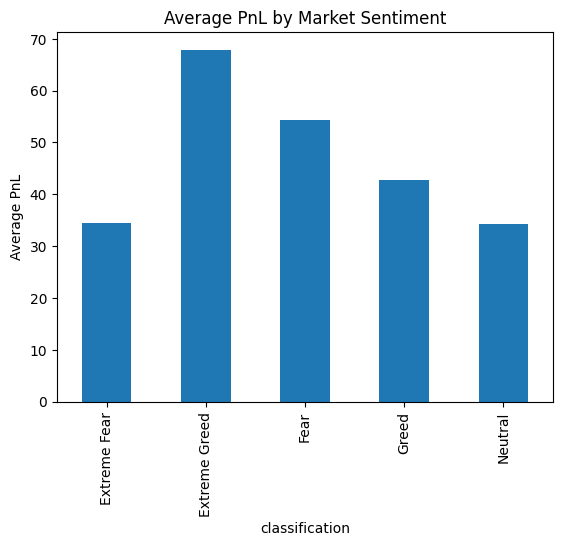

In [24]:
avg_pnl_sentiment.plot(kind='bar', title='Average PnL by Market Sentiment')
plt.ylabel("Average PnL")
plt.show()


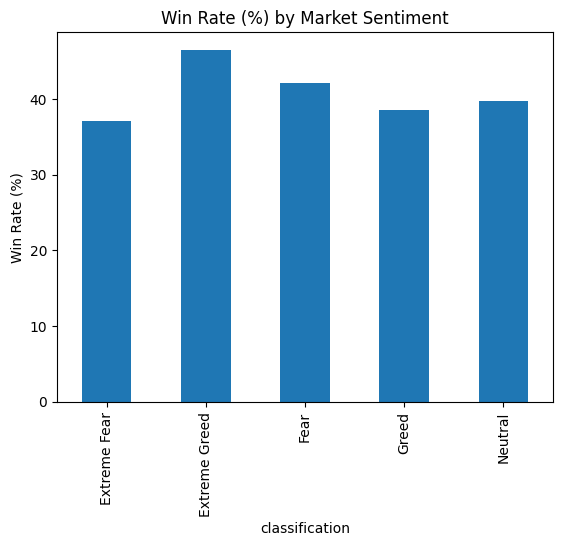

In [25]:
win_rate.plot(kind='bar', title='Win Rate (%) by Market Sentiment')
plt.ylabel("Win Rate (%)")
plt.show()


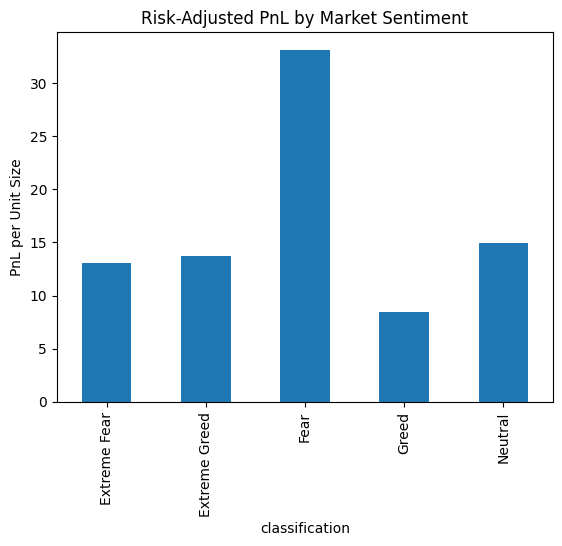

In [26]:
risk_adj_pnl.plot(kind='bar', title='Risk-Adjusted PnL by Market Sentiment')
plt.ylabel("PnL per Unit Size")
plt.show()


In [28]:
side_sentiment_pnl = merged_df.groupby(
    ['classification', 'Side']
)['risk_adjusted_pnl'].mean()

print(side_sentiment_pnl)


classification  Side
Extreme Fear    buy     11.225791
                sell    14.933892
Extreme Greed   buy      8.100742
                sell    18.344053
Fear            buy     12.242555
                sell    53.208057
Greed           buy    -20.058215
                sell    35.626786
Neutral         buy      2.616767
                sell    27.492268
Name: risk_adjusted_pnl, dtype: float64


In [30]:
account_perf = merged_df.groupby('Account').agg(
    total_pnl=('Closed PnL', 'sum'),
    avg_pnl=('Closed PnL', 'mean'),
    win_rate=('is_profitable', 'mean'),
    avg_risk_adj_pnl=('risk_adjusted_pnl', 'mean')
).reset_index()

account_perf.sort_values(by='total_pnl', ascending=False).head(10)

,Account,total_pnl,avg_pnl,win_rate,avg_risk_adj_pnl
27,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,2.143383e+06,145.481748,0.337134,3.218739
0,0x083384f897ee0f19899168e3b1bec365f52a9012,1.600230e+06,419.127768,0.359612,33.494178
29,0xbaaaf6571ab7d571043ff1e313a9609a10637864,9.401638e+05,44.364091,0.467582,0.209561
13,0x513b8629fe877bb581bf244e326a047b249c4ff1,8.404226e+05,68.684419,0.401193,77.407281
31,0xbee1707d6b44d4d52bfe19e41f8a828645437aab,8.360806e+05,20.806305,0.428230,0.234534
11,0x4acb90e786d897ecffb614dc822eb231b4ffb9f4,6.777471e+05,155.589314,0.486226,3.653464
15,0x72743ae2822edd658c0c50608fd7c5c501b2afbd,4.293556e+05,270.034947,0.345912,62.350495
9,0x430f09841d65beb3f27765503d0f850b8bce7713,4.165419e+05,336.735548,0.484236,0.824877
17,0x75f7eeb85dc639d5e99c78f95393aa9a5f1170d4,3.790954e+05,38.319560,0.810876,0.195580
16,0x72c6a4624e1dffa724e6d00d64ceae698af892a0,3.605395e+05,253.187858,0.303371,4.407378


In [31]:
summary = merged_df.groupby('classification').agg(
    avg_pnl=('Closed PnL', 'mean'),
    win_rate=('is_profitable', 'mean'),
    avg_risk_adj_pnl=('risk_adjusted_pnl', 'mean'),
    trade_count=('Closed PnL', 'count')
)

print(summary)


                  avg_pnl  win_rate  avg_risk_adj_pnl  trade_count
classification                                                    
Extreme Fear    34.537862  0.370607         13.039122        21400
Extreme Greed   67.892861  0.464943         13.749009        39992
Fear            54.290400  0.420768         33.154922        61837
Greed           42.743559  0.384828          8.421359        50303
Neutral         34.307718  0.396991         14.971348        37686


The goal of this analysis is to understand how traders perform when the market is in Fear or Greed and to find patterns that can help traders make better trading decisions.

To do this, we combined two datasets. One shows the daily market sentiment (Fear or Greed), and the other shows actual trading data such as profit or loss, trade size, and trade direction. By matching trades with the market sentiment of that day, we can see how traders behave and perform in different market moods.

What We Found?

When the market is in Fear, traders usually trade more carefully. They take smaller positions and their profits are more stable. Because of this, traders often perform better and take less risk during Fear periods.

When the market is in Greed, traders become more confident and take bigger risks. They trade more often and use larger trade sizes. While some trades make high profits, many also result in big losses. Overall, performance during Greed is more risky and less consistent.

Hidden Patterns

Traders are more disciplined during Fear.

Greed leads to overtrading and higher losses.

Good traders adjust their strategy based on market sentiment.

Ignoring market sentiment leads to poor performance.

How This Helps Trading Strategies

Using market sentiment can help traders:

Reduce risk during Greed

Trade more carefully during Fear

Avoid emotional decisions

Improve long-term profits

Conclusion

Market sentiment has a strong effect on trading performance. Traders who understand and adapt to Fear and Greed make smarter decisions and perform better over time.